In [1]:
import os 
os.chdir("..") 
print(os.getcwd())

/Users/282066/Documents/PHD/Importance Sampling/importance-sampling


In [19]:
from scipy.io import loadmat
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

from src.importance_sampling.sampling import ImportanceSampler
from src.utils.analysis_utils import prepare_embeddings, summarize_all_metrics
from src.utils.visualisation import plot_metric_bars, plot_pca_tripanel_hexbin, plot_pca_joint_kde, plot_two_panel_barplot


In [3]:
# Set paths
DATA_PATH = "data/processed/nli_combined.pkl"

In [4]:
# Load data
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df)} rows")

Loaded 19832 rows


In [5]:
# Inspect structure
df["source"].value_counts()

source
snli_test                     10000
mnli_validation_mismatched     9832
Name: count, dtype: int64

In [6]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality

features = "cls_embedding"  # or "mean_embedding"
use_pca = True  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=15)


Applying PCA to reduce from 768 to 15 dimensions...
Total variance explained by 15 components: 88.46%


In [7]:
# Define domains
df_source = df[df["source"].str.contains("snli_test")]
df_target = df[df["source"].str.contains("mnli_validation_mismatched")]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 10000 samples
Target: 9832 samples


In [8]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = ['premise', 'hypothesis', 'label', 'source', 'cls_embedding',
       'mean_embedding', 'predicted_label_text', 'predicted_label', 'sbert_embedding']

In [9]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)

Current best logistic target prob avg at iter 1: 0.171


In [10]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df = summarize_all_metrics(datasets, label_col='label', pred_col='predicted_label', 
                                   n_bootstrap=1000, average = 'weighted')
print(results_df)

        set     metric      mean     lower     upper
0    Source  precision  0.889176  0.883040  0.895538
1    Source     recall  0.888964  0.882798  0.895303
2    Target  precision  0.738389  0.729388  0.747206
3    Target     recall  0.738048  0.729040  0.746651
4    Sample  precision  0.822716  0.798441  0.846029
5    Sample     recall  0.817697  0.793000  0.842000
6  Weighted  precision  0.816304  0.802522  0.831226
7  Weighted     recall  0.815497  0.801767  0.830486


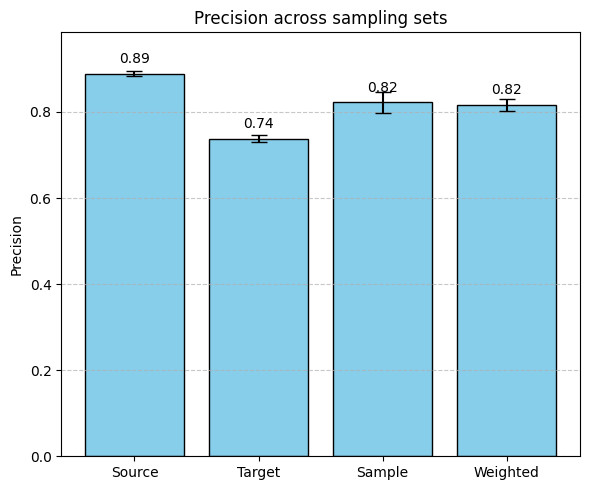

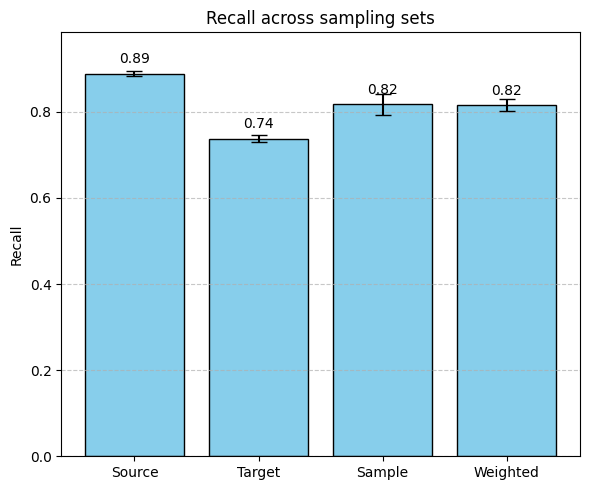

In [11]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

### General BERT sentence embedding

In [12]:
# (Optional) Apply PCA
# This can make later visualizations easier and reduce dimensionality
df = pd.read_pickle(DATA_PATH)

features = "sbert_embedding"  # or "mean_embedding"
use_pca = False  # toggle between full embedding or PCA

df = prepare_embeddings(df, embedding_col=features, use_pca= use_pca, n_components=50)


Using full embedding of size 768...


In [13]:
# Define domains
df_source = df[df["source"].str.contains("snli_test")]
df_target = df[df["source"].str.contains("mnli_validation_mismatched")]

print(f"Source: {len(df_source)} samples")
print(f"Target: {len(df_target)} samples")

Source: 10000 samples
Target: 9832 samples


In [14]:
# Set parameters 
N_ITERS = 100
N_SAMPLES = 1000
ignore_columns = ['premise', 'hypothesis', 'label', 'source', 'cls_embedding',
       'mean_embedding', 'predicted_label_text', 'predicted_label', 'sbert_embedding']

In [15]:
# Run importance sampling 
imp = ImportanceSampler(source=df_source, target=df_target, ignore_cols=ignore_columns)
imp.fit()
df_sample, _, df_weighted = imp.sample(n=N_SAMPLES, attempts=N_ITERS)
# imp.plot(df_sample, maxcols=3)

Current best logistic target prob avg at iter 1: 0.072


In [16]:
# Compute metrics 
datasets = {
    "Source": df_source,
    "Target": df_target,
    "Sample": df_sample,
    "Weighted": df_weighted,
}

results_df_2 = summarize_all_metrics(datasets, label_col='label', pred_col='predicted_label', 
                                   n_bootstrap=1000, average = 'weighted')
print(results_df_2)

        set     metric      mean     lower     upper
0    Source  precision  0.889176  0.883040  0.895538
1    Source     recall  0.888964  0.882798  0.895303
2    Target  precision  0.738389  0.729388  0.747206
3    Target     recall  0.738048  0.729040  0.746651
4    Sample  precision  0.889062  0.868434  0.907681
5    Sample     recall  0.887732  0.867000  0.906025
6  Weighted  precision  0.889584  0.881139  0.897936
7  Weighted     recall  0.889427  0.881051  0.897906


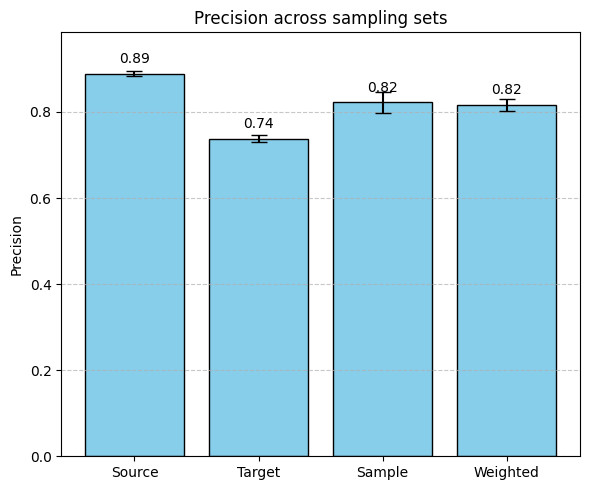

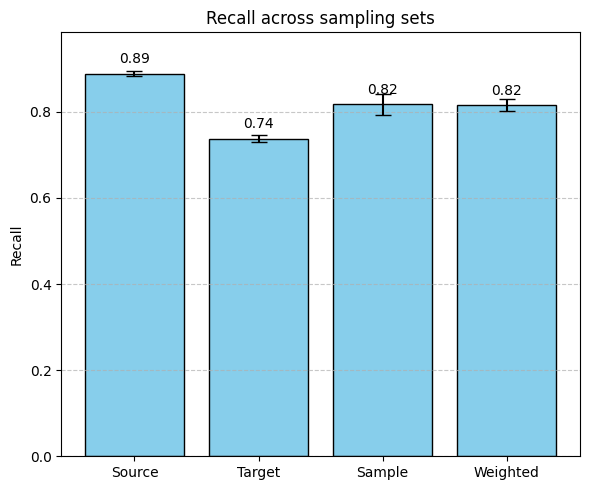

In [17]:
# Plot metrics
plot_metric_bars(results_df, metric="precision", title="Precision across sampling sets")
plot_metric_bars(results_df, metric="recall", title="Recall across sampling sets")

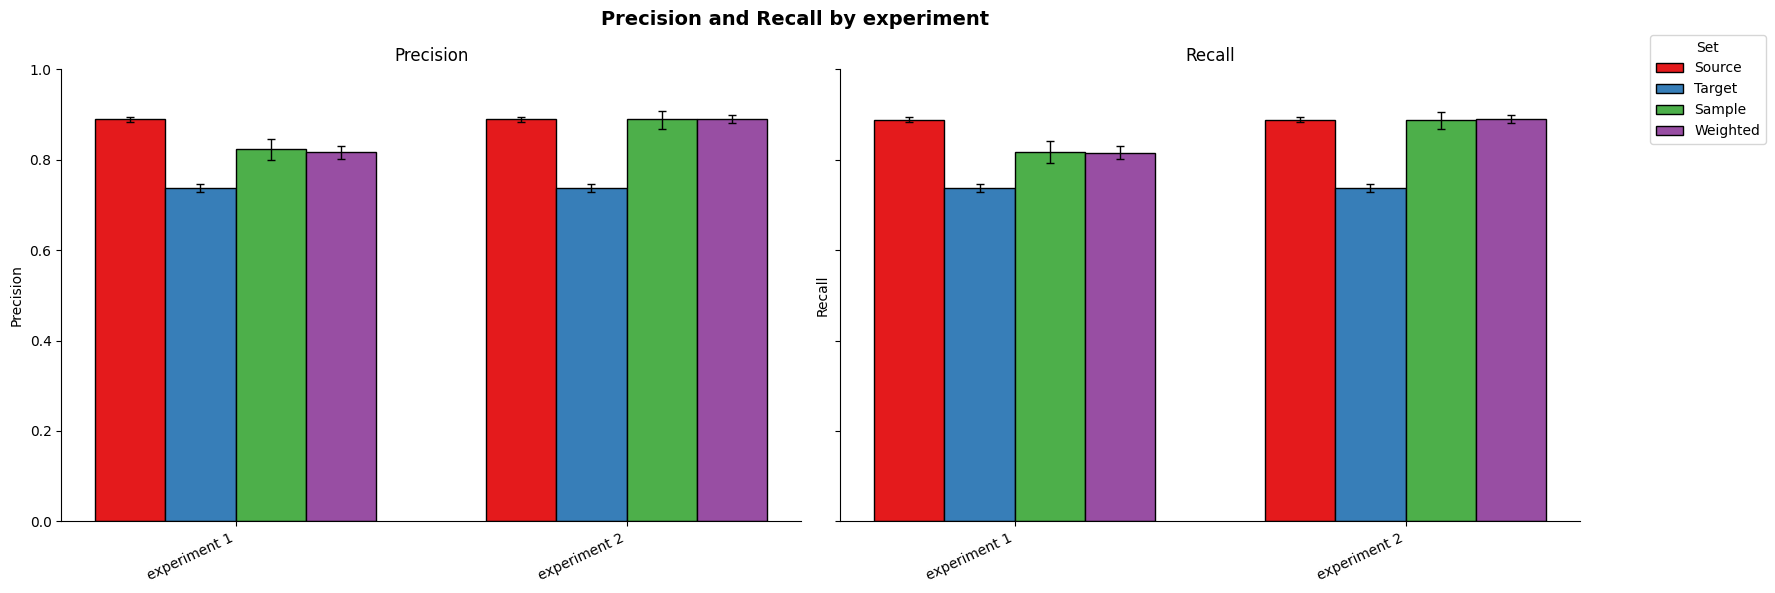

In [20]:
results = {
    "experiment 1": results_df,
    "experiment 2": results_df_2,
}

plot_two_panel_barplot(
    results)
plt.show()
